# DCGANの作成

# 5.1 学習目標

1.	Generatorが画像を生成するためにどのようなニューラルネットワークの構造になっているのかを理解する
2.	Discriminatorが画像の識別をするためにどのようなニューラルネットワークの構造になっているのかを理解する
3.	GANの一般的な損失関数の形とニューラルネットワークの学習の流れを理解する
4.	DCGANのネットワークを実装できるようになる

# 5.2 学習目標

1.	GANの損失関数の形を理解する
2.	DCGANを実装し、手書き数字画像が生成できる

## Library

In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

## Deconvolution(ConvTranspose2d, 転置畳み込み)

In [4]:
input = torch.tensor([[[[1., 1.], [2., 2.]]]])
print("入力データ")
print(input)
print("-----")

print("通常の畳み込み")
m = nn.Conv2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

print("-----")
print("転置畳み込み")
m = nn.ConvTranspose2d(1, 1, 2, stride=1, bias=False)
m.weight[0, 0, 0, 0] = 1
m.weight[0, 0, 0, 1] = 2
m.weight[0, 0, 1, 0] = 3
m.weight[0, 0, 1, 1] = 4
print("カーネル")
print(m.weight)
print("出力")
print(m(input))

入力データ
tensor([[[[1., 1.],
          [2., 2.]]]])
-----
通常の畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[17.]]]], grad_fn=<MkldnnConvolutionBackward>)
-----
転置畳み込み
カーネル
Parameter containing:
tensor([[[[1., 2.],
          [3., 4.]]]], grad_fn=<CopySlices>)
出力
tensor([[[[ 1.,  3.,  2.],
          [ 5., 13.,  8.],
          [ 6., 14.,  8.]]]], grad_fn=<SlowConvTranspose2DBackward>)


## Generatorの実装

In [8]:
class Generator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()
        
        # ConvTranspose2dでchannelのサイズを1まで落としていく
        # 白黒画像なので出力チャネルは一つだけ
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1), 
            nn.BatchNorm2d(image_size*8), 
            nn.ReLU(inplace=True))
        
        self.layers2 = nn.Sequential(
                nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(image_size*4),
                nn.ReLU(inplace=True))

        self.layers3 = nn.Sequential(
                nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(image_size*2),
                nn.ReLU(inplace=True))
        
        self.layers4 = nn.Sequential(
                nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(image_size),
                nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
                nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
                nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layers2(out)
        out = self.layers3(out)
        out = self.layers4(out)
        out = self.last(out)
        
        return out
        

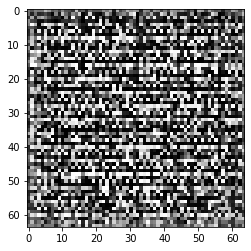

(64, 64)


In [13]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)
# torch.Size([1, 20, 1, 1])  N,C,H,Wの形に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)  

# 偽画像を出力
fake_images = G(input_z)
img_transformed = fake_images[0][0].detach().numpy()  # 勾配情報を切り捨ててnumpyに変換
plt.imshow(img_transformed, 'gray')
plt.show()

print(img_transformed.shape) # 1,1 -> 64, 64

## Discriminatorの実装

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()
        
        # 白黒と画像なので最初channelは１
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeaklyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeaklyReLU(0.1, inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.LeaklyReLU(0.1, inplace=True))
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeaklyReLU(0.1, inplace=True))
        
        # 最終的に偽物か本物か判断するので１次元にする
        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out